# DATA

Height change data (ATL15) is technically available but all .nc files are empty. Thus we use **ATLAS/ICESat-2 L3B Gridded Antarctic and Arctic Land Ice Height V004** data (ATL14) instead and caclulate average yearly height change from there.

In NASA Earthdata search look for *ATLAS/ICESat-2 L3B* to find related data sets.

Characteristics:
- data resolution: 100 m res
- regions: A3 and A4
- 01/01/2019 (start) - 31/12/2024 (end) -> 5 year average, 4 time slices per year
- relative to 2020
- calculate yearly average change

We use the following two data sets:
- ATL15_A3_0325_01km_004_05.nc (1.2 GB)
- ATL15_A4_0325_01km_004_05.nc (2.5 GB)

In [2]:
import numpy as np
import pandas as pd

# xarray >= 2024.10.0 for data tree
import xarray as xr
import torch
import matplotlib.pyplot as plt

In [3]:
path_a3 = "/home/kim/data/icesat2/ATL15_A3_0325_01km_004_05.nc"
path_a4 = "/home/kim/data/icesat2/ATL15_A4_0325_01km_004_05.nc"

# NOTE: This does not work
# a3 = xr.open_dataset(path_a3)
# NOTE: These nc files can only be opened as a datatree
a3_tree = xr.open_datatree(path_a3)
a4_tree = xr.open_datatree(path_a4)

# Now make DataSet
a3 = xr.Dataset(a3_tree.delta_h)
a4 = xr.Dataset(a4_tree.delta_h)

print(a3.data_vars)
print(a4.data_vars)

Data variables:
    Polar_Stereographic  int8 1B ...
    ice_area             (time, y, x) float32 278MB ...
    delta_h              (time, y, x) float32 278MB ...
    delta_h_sigma        (time, y, x) float32 278MB ...
    data_count           (time, y, x) float32 278MB ...
    misfit_rms           (time, y, x) float32 278MB ...
    misfit_scaled_rms    (time, y, x) float32 278MB ...
Data variables:
    Polar_Stereographic  int8 1B ...
    ice_area             (time, y, x) float32 612MB ...
    delta_h              (time, y, x) float32 612MB ...
    delta_h_sigma        (time, y, x) float32 612MB ...
    data_count           (time, y, x) float32 612MB ...
    misfit_rms           (time, y, x) float32 612MB ...
    misfit_scaled_rms    (time, y, x) float32 612MB ...


# Subset Ross coords

In [4]:
x_min = - 600_000
x_max = 400_000
# y_min = - 1_400_000
# Increase so both have same y range and merge is easier
y_min = - 1_390_000
y_max = - 400_000

a3_ross = a3.sel(x = slice(x_min, x_max), y = slice(y_min, y_max))
a4_ross = a4.sel(x = slice(x_min, x_max), y = slice(y_min, y_max))

# Combine both

In [48]:
# NOTE: minor issue with attributes, so override
ross_icesat2 = xr.combine_by_coords([a3_ross, a4_ross], combine_attrs = "override")

# ross_icesat2.time
# Note: 2020-12-31, 2024-12-31

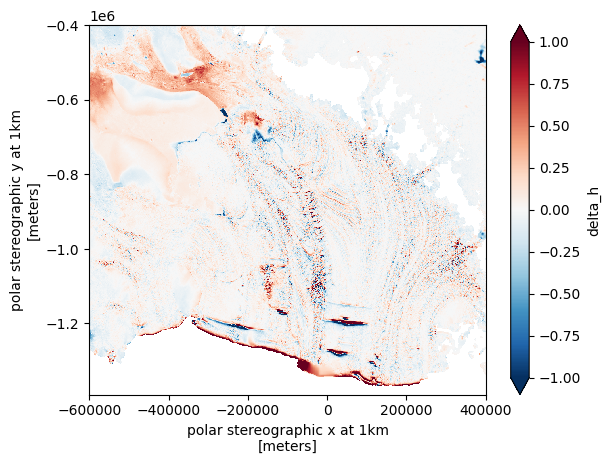

In [ ]:
# Extract height change DataArray
dh = ross_icesat2.delta_h

# Explicit year slices (start inclusive, end exclusive)
year_slices = [
    ("2019-01-01", "2020-01-01"),
    ("2020-01-01", "2020-12-31"), # Note
    ("2021-01-01", "2022-01-01"),
    ("2022-01-01", "2023-01-01"),
    ("2023-01-01", "2024-01-01"),
    ("2024-01-01", "2024-12-31"), # Note
]

dh_yearly_change = []
for start, end in year_slices:
    dh_start = dh.sel(time = start, method = "nearest")
    dh_end = dh.sel(time = end, method = "nearest")
    dh_change = dh_end - dh_start
    dh_yearly_change.append(dh_change)

# Combine into one DataArray with 'year' dimension
years = np.arange(2019, 2019 + len(year_slices))
dh_yearly_change = xr.concat(dh_yearly_change, dim = "year")
dh_yearly_change = dh_yearly_change.assign_coords(year=years)

# Optional: convert to rate (m yr⁻¹)
dh_rate_yearly = dh_yearly_change

# Mean annual thinning (2019 – 2024)
mean_thinning_rate = dh_rate_yearly.mean("year")

# Plot
mean_thinning_rate.plot(cmap = "RdBu_r", vmin = -1, vmax = 1)

# The years are quite diverse

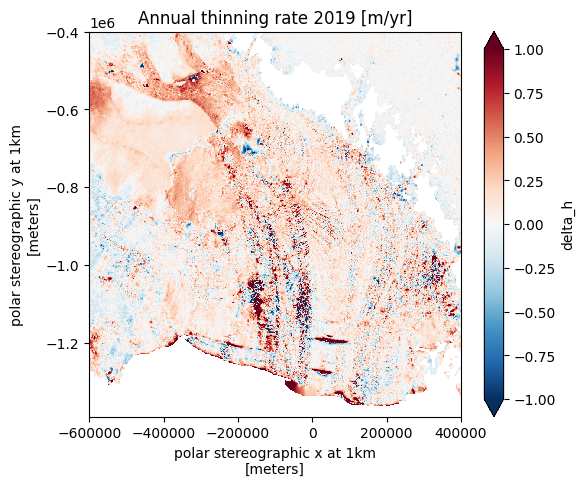

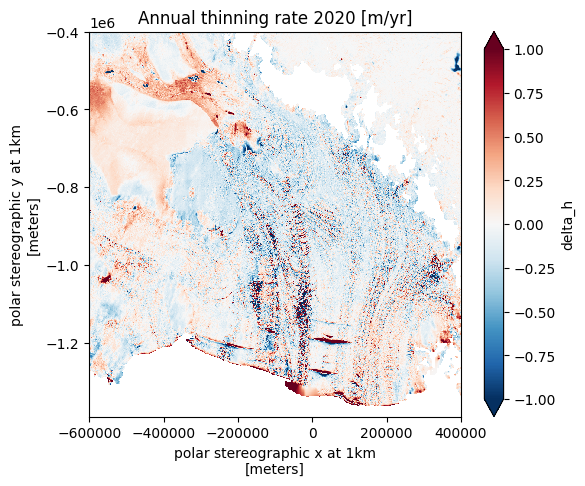

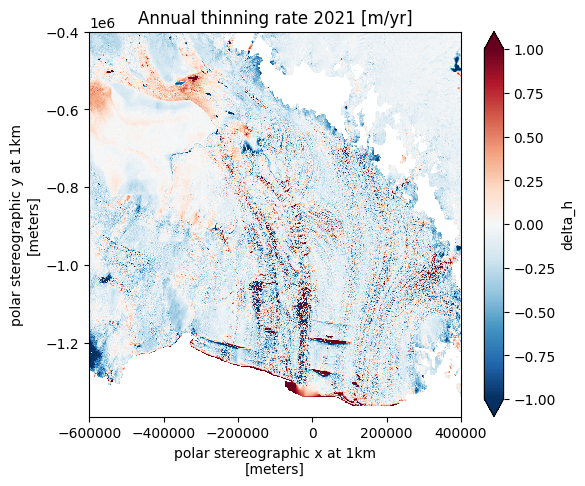

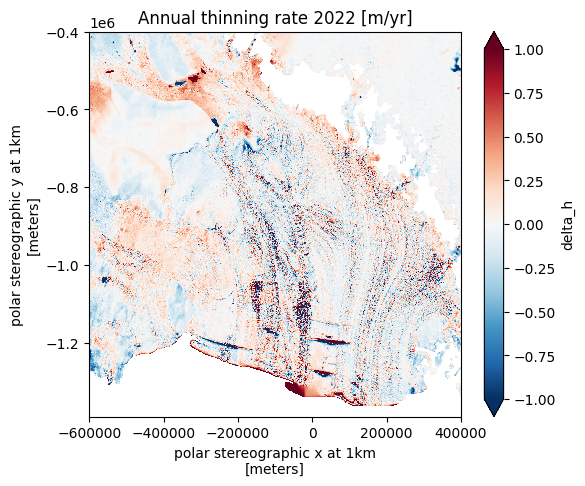

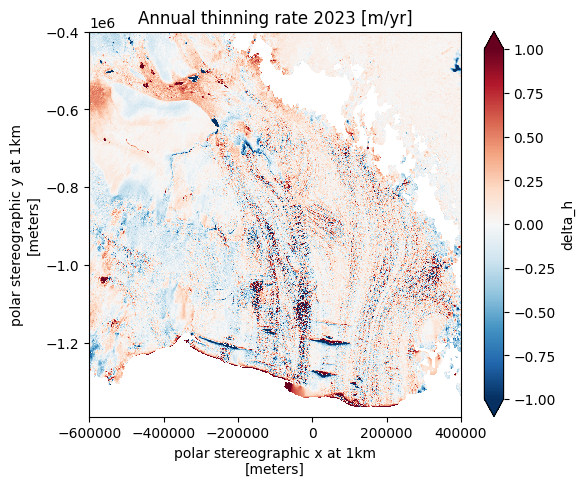

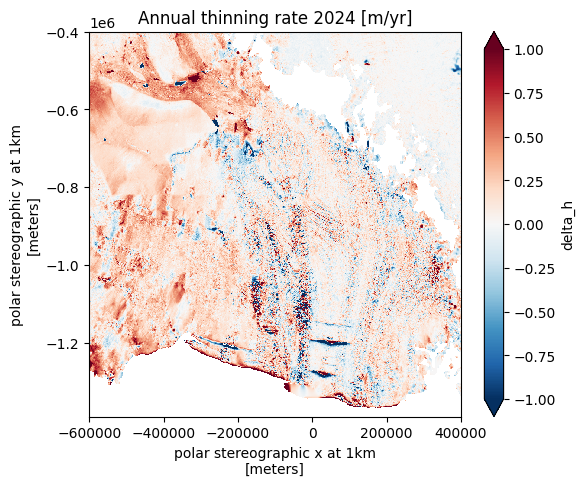

In [ ]:
import matplotlib.pyplot as plt

for yr in dh_rate_yearly.year.values:
    plt.figure(figsize = (6,5))
    dh_rate_yearly.sel(year = yr).plot(
        cmap = "RdBu_r", vmin = -1, vmax = 1, robust = True
    )
    plt.title(f"Annual thinning rate {int(yr)} [m/yr]")
    plt.show()

In [ ]:
q1 = ross_icesat2.delta_h.sel(time = "2019-04-02").squeeze("time") - ross_icesat2.delta_h.sel(time = "2019-01-01").squeeze("time")
q2 = ross_icesat2.delta_h.sel(time = "2019-07-02") - ross_icesat2.delta_h.sel(time = "2019-04-02")
q3 = ross_icesat2.delta_h.sel(time = "2019-10-02") - ross_icesat2.delta_h.sel(time = "2019-07-02")
q4 = ross_icesat2.delta_h.sel(time = "2020-01-01") - ross_icesat2.delta_h.sel(time = "2019-10-02")

# Add quarters differences
mean_2019 = (q1 + q2 + q3 + q4)

mean_2019.plot(cmap = "RdBu_r", vmin = -0.5, vmax = 0.5)
plt.title("Mean quarterly height change 2019 (m)")

TypeError: No numeric data to plot.

In [ ]:
q1

<xarray.DataArray 'delta_h' (time: 1, y: 991, x: 1002)> Size: 4MB
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.12524414,  0.12493896,  0.12579346, ..., -0.00500488,
         -0.00921631, -0.01611328],
        [ 0.10955811,  0.10644531,  0.12249756, ..., -0.01690674,
         -0.00732422,  0.00463867],
        [ 0.10528564,  0.09588623,  0.08648682, ..., -0.00299072,
         -0.00256348,  0.0135498 ]]], dtype=float32)
Coordinates:
  * x        (x) float64 8kB -6e+05 -5.99e+05 -5.98e+05 ... 3.99e+05 4e+05
  * y        (y) float64 8kB -1.39e+06 -1.389e+06 ... -4.01e+05 -4e+05
  * time     (time) datetime64[ns] 8B 2019-04-02T13:30:00
Attributes:
    units:         meters
    dimensions:    time,y,x
    datatype:      float32
    description:   Height change relative to the datum (Jan 1, 2020) surface
    long_name:     height change  at 1 km
    source:        ATBD section 3.4
    grid_mapping:  Polar_Stereographic

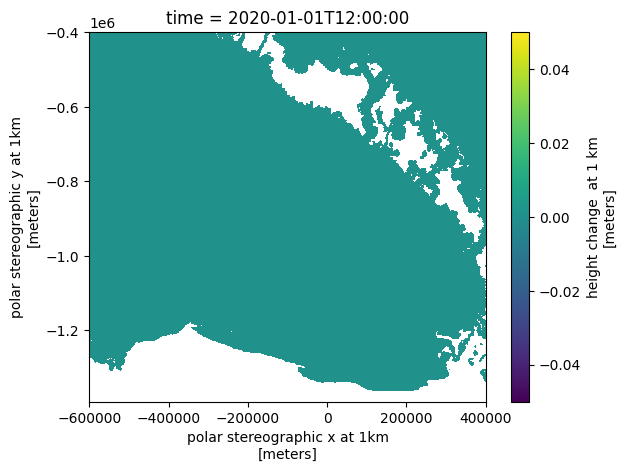

In [ ]:
# Reference data
# ross_icesat2.delta_h.sel(time = "2020-01-01").plot()

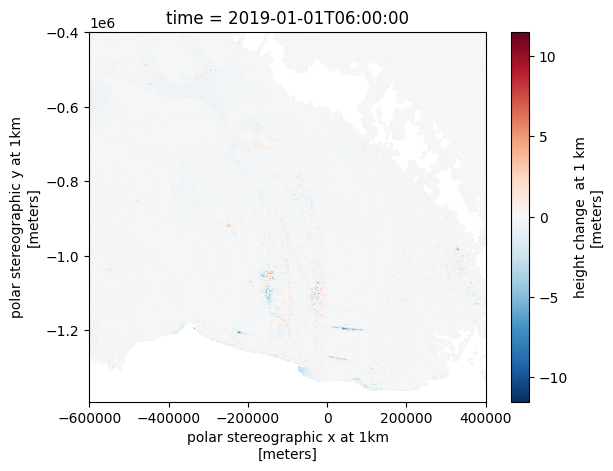

In [19]:
ross_icesat2.delta_h.isel(time = 0).plot()

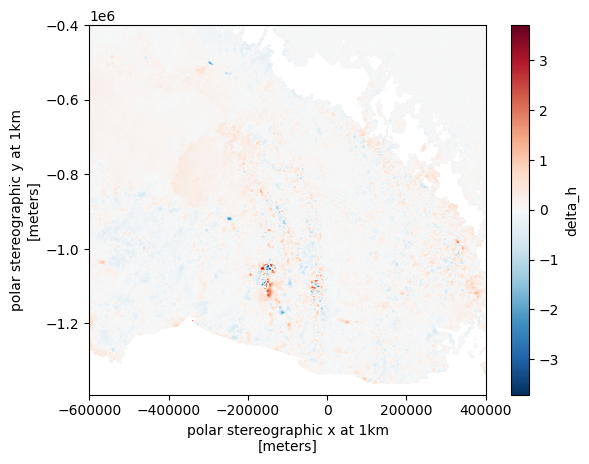

In [21]:
(ross_icesat2.delta_h.isel(time = 1) - ross_icesat2.delta_h.isel(time = 0)).plot()

In [18]:
ross_icesat2

<xarray.Dataset> Size: 596MB
Dimensions:              (x: 1002, time: 25, y: 991)
Coordinates:
  * x                    (x) float64 8kB -6e+05 -5.99e+05 ... 3.99e+05 4e+05
  * y                    (y) float64 8kB -1.39e+06 -1.389e+06 ... -4e+05
  * time                 (time) datetime64[ns] 200B 2019-01-01T06:00:00 ... 2...
Data variables:
    Polar_Stereographic  (x) int8 1kB -127 -127 -127 -127 ... -127 -127 -127
    ice_area             (time, y, x) float32 99MB nan nan ... 1.052e+06
    delta_h              (time, y, x) float32 99MB nan nan ... 0.05731 0.01471
    delta_h_sigma        (time, y, x) float32 99MB nan nan ... 0.01062 0.01013
    data_count           (time, y, x) float32 99MB nan nan nan ... 10.29 9.452
    misfit_rms           (time, y, x) float32 99MB nan nan ... 0.02948 0.02527
    misfit_scaled_rms    (time, y, x) float32 99MB nan nan nan ... 1.693 1.586